In [94]:
%reset -f

In [95]:
import numpy as np
import pandas as pd

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.special import expit as sigmoid

from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, \
                                    GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer, r2_score, recall_score 
from sklearn.externals.joblib import parallel_backend
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression, make_classification
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Lasso, LinearRegression

import xgboost as xgb
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [96]:
def pp(num, string=None):
    to_print = '{0:.3e}'.format(num)
    if string is not None:
        to_print = string + ': ' + to_print
    print(to_print)
    return

In [97]:
def plot_metric(param_name, param_values, train_values=None, val_values=None, log_x=False):
    plt.figure(figsize=(16, 8))
    if train_values is not None:
        plt.plot(param_values, train_values, 'o-', label='train')
    if val_values is not None:
        plt.plot(param_values, val_values, 'o-', label='val')

    plt.xlabel(param_name)
    if log_x:
        plt.xscale('log')
    plt.ylabel('metric')
    plt.legend(loc='best')
    plt.title(param_name)
    plt.show()

## Часть 1. Реализация градиентного бустинга

Нужно реализовать класс для модели градиентного бустинга на деревьях (3 балла) и вспомогательные классы для функций потерь MSE (1 балл) и BCE (1 балл).

За что можно получить дополнительные баллы:
- Реализация ранней остановки обучения (1 балл)
- Реализация вычисления дополнительной метрики качества на каждой итерации (1 балл)
- Реализация бэггинга при обучении отдельных деревьев (1 балл)

### 1. Функции потерь

Начнем с функций потерь. Нам нужны будут две функции потерь, одна для задачи классификации и одна для задачи регрессии. Для каждой из них напишем отдельный класс, который позволит вычислять как саму функцию потерь, так и ее градиент.

#### 1.1. Базовый класс Loss

Сначала напишем базовый класс `Loss`, от которого будем наследоваться при написании функций потерь.
Вычисление значения функции потерь будет производиться в методе `forward`, а градиента - в методе `backward`.

Метод `forward` должен получать на вход два вектора: вектор целевых переменных и вектор предсказаний модели.
Метод должен: 
* проверять, что длины векторов совпадают (с помощью `assert`)
* возвращать вектор той же длины, содержащий значения функции потерь для каждого из объектов

Метод `grad` должен делать то же самое, но возвращать значение градиента функции потерь.

In [98]:
class Loss(object):
    
    def __call__(self, y, p):
        """
        Call and use .forward()
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        return self.forward(y, p)
        
    def forward(self, y, p):
        """
        Calculate loss value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        raise NotImplementedError
        
    def grad(self, y, p):
        """
        Calculate grad value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like grad values
        """
        raise NotImplementedError

#### 1.2. Функция потерь для задачи регрессии (MSE)

Для задачи регрессии будем использовать `Mean Squared Error (MSE)`:

$$L = MSE(y,p) = \frac{1}{2n}(y - p) ^ 2$$

Ее градиент:
$$\frac{\partial L}{\partial p} = \frac{1}{n}(p - y)$$

В формулах выше `p` - предсказания модели.

In [99]:
class MSELoss(Loss):
    
    def forward(self, y, p):
        n = len(y)
        assert(n == len(p))
        mse = 0.5 / n * np.square(y - p) 
        return mse
    
    def grad(self, y, p):
        n = len(y)
        assert(n == len(p))
        grad = 1. / n * (p - y)
        return grad

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [100]:
mse_loss = MSELoss()

ys = np.array((10, 20, 30))
ps = np.array((5, 25, 30))

np.testing.assert_raises(AssertionError, mse_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, mse_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_almost_equal(mse_loss(ys, ps), np.asarray([4.16667, 4.1666, 0]), decimal=4)
np.testing.assert_almost_equal(mse_loss.grad(ys, ps), np.asarray([-1.66667, 1.66667, 0]), decimal=4)

Если ошибок нет, можно переходить к следующей части.

#### 1.3. Функция потерь для задачи классификации (BCE)

Для задачи регрессии будем использовать `Binary Cross-Entropy (BCE)`:
$$L = BCE(y,p) = \frac{1}{n}(-y \log{p} - (1-y)\log{(1-p)})$$

Ее градиент по `p`:
$$\frac{\partial L}{\partial p} = \frac{(p - y)}{p(1-p)}$$

Вспомним, что для вычисления `p` используется сигмоида:
$$p = \sigma (z) = \frac{1}{1 + \exp (-z)}$$
$$\sigma (z)' = \sigma (z) (1 - \sigma (z))$$

Подставив последнее выражение в градиент функции потерь, получим аналогичное `MSE` выражение:
$$\frac{\partial L}{\partial z} = \frac{1}{n}(\sigma (z) - y)$$

В формулах выше `z` - предсказания модели до применения сигмоиды, `p` - после.

**Важно:** для дальнейшего удобства методы `forward` и `grad` в качестве предсказаний должны получать `z`, **активации** модели, то есть результат вычислений модели без взятия сигмоиды от них; сигмоидальное преобразования реализуется внутри этих методов (см.код).

**Важно:** не забудьте при вычислении логарифмов добавить отсечку значений аргумента значениями (`eps`, 1 - `eps`) в избежание ошибок арифметики.

In [101]:
class BCEWithLogitsLoss(Loss):
    
    eps = 1e-5

    def forward(self, y, z):
        p = sigmoid(z)
        # Your code here
        eps = self.eps
        n = len(y)
        assert(n == len(p))
        
        p[y.astype(bool) & (p < eps)] = eps
        p[~y.astype(bool) & (1 - p < eps)] = 1 - eps
    
        loss = -1. / n * ( y * np.log(p) + (1 - y) * np.log(1 - p) )
        
        return loss
    
    def grad(self, y, z):
        p = sigmoid(z)
        # Your code here
        n = len(y)
        assert(n == len(p))
                
        grad = 1. / n * (p - y)
        
        return grad

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [102]:
bce_loss = BCEWithLogitsLoss()

ys = np.array((1, 0, 0))
zs = np.array((0.0, 100.0, 1.0))

np.testing.assert_raises(AssertionError, bce_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, bce_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_array_less(bce_loss(ys, zs), np.inf)

np.testing.assert_almost_equal(bce_loss(ys, zs), np.asarray([0.231 , 3.8376, 0.4378]), decimal=4)
np.testing.assert_almost_equal(bce_loss.grad(ys, zs), np.asarray([-0.1667,  0.3333,  0.2437]), decimal=4)

Если ошибок нет, можно переходить к следующей части.

### 2. Градиентный бустинг

#### 2.1. Класс GradentBoosting
После того, как были получены классы для функций потерь, можно приступать к реализации класса для градиентного бустинга `GradientBoosting`.
В качестве базовых моделей будем использовать деревья решений (`DecisionTreeRegressor` из `sklearn.tree`).
Итоговый вид композиции:
$$a(x) = \sum_{t=1}^{T}\eta * b_{t}(x)$$

Параметры класса (аргументы метода `__init__()`):
* `loss`: объект одного из двух классов, реализованных выше (`MSELoss` или `BCELoss`), будет определять поведение при вызове метода `predict()`.
* `n_estimators`: число деревьев `T` (итераций бустинга)
* `learning_rate`: темп обучения (коэффициент $\eta$)
* `max_depth`: максимальная глубина построенных деревьев (параметр `DecisionTreeRegressor`)
* `max_features`: число признаков для поиска наилучшего разбиения в узле (параметр `DecisionTreeRegressor`)

В методе `__init__()` создаются списки для хранения отдельных деревьев (`self.estimators`) и значений функции потерь на каждом шаге (`self.loss_values`).
Также имеется дополнительное поле `self.loss_values_evalset`, в котором можно хранить значения функции потерь на отложенной (`evalset`) выборке по итерациям.

Метод `fit(X, y, X_eval=None, y_eval=None)` должен:
* Инициализировать "нулевое приближение" средним значением целевой переменной, считать значение потерь при нем
* Итерируясь по числу деревьев:
  * Вычислять **антиградиент** функции потерь построенной композиции по каждому объекту (остатки), создавать новое дерево, обучать его на полученных остатках и добавлять в список деревьев.
  * Вычислять новое значение предсказания композиции для обучающей выборки (добавлением ответов нового дерева с весом $\eta$)
  * Считать новое значение функции потерь (суммарно по всем объектам) и добавлять в список
* В случае, если методу передаются также `X_eval` и `y_eval`, нужно вычислять значение функции потерь на этом множестве на каждой итерации.
  
Метод `predict(X)` должен:
* Для каждого объекта из `X` делать предсказание с помощью всех деревьев композиции  (**не забывайте про "нулевое приближение"**) и суммировать их
* Если решается задача классификации, применять сигмоиду на полученных ответах

In [103]:
class GradientBoosting(BaseEstimator):
    
    def __init__(self, 
                 loss=None,
                 n_estimators=10, 
                 learning_rate=0.1,
                 max_depth=3,
                 max_features='auto',
                 subsample = 1,
                 early_stopping_rounds = None,
                 eps = 1e-3,
                 random_state=2):
        self.loss = loss
        
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        
        self.max_depth = max_depth          # ok
        self.max_features = max_features    # ok
        
        self.estimators = []          # list, containing my pretty trees
        self.loss_values = []         # list, containing loss values on every boosting iteration
        self.loss_values_evalset = [] # list, containing loss values on evaluation set on every boosting iteration 
        self.metric_values_evalset = [] # list, containing additional metrics values on evaluation set
        
        self.random_state = random_state
        self.zero_approx = 0.0
        
        self.early_stopping_rounds = early_stopping_rounds
        self.idle_iters = 0
        self.eps = eps
        self.prev_eval_loss = 0
        
        self.subsample = subsample
    
    def fit(self, X, y, X_evalset=None, y_evalset=None, verbose=False):
        # Your code here
        self.zero_approx = np.rint(y.mean())
        p = self.zero_approx * np.ones(len(y))
        
        
        loss = np.sum( self.loss(y, p) )
        self.loss_values.append(loss)
        
        n = y.shape[0]
        for t in range(self.n_estimators):
            # Your code here
            grad = self.loss.grad(y, p)
            target = -grad
            
            # bagging
            idx = np.random.choice(n, size=int(np.rint(n * self.subsample)), replace=False)
            
            regressor = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.max_features)
            regressor.fit(X[idx], target[idx])
            self.estimators.append(regressor)
            
            p += self.learning_rate * regressor.predict(X)
            
            loss = np.sum( self.loss(y, p) )
            self.loss_values.append(loss)
            
            if X_evalset is not None and y_evalset is not None:
                p_eval = self.predict(X_evalset)
                eval_loss = np.sum( self.loss(y_evalset, p_eval) )
                self.loss_values_evalset.append(eval_loss)
                
                # compute r2 or recall
                if isinstance(self.loss, MSELoss):
                    self.metric_values_evalset.append( r2_score(y_evalset, p_eval) )
                elif isinstance(self.loss, BCEWithLogitsLoss):
                    p_labels = np.array(p_eval > 0.5, dtype=np.int)
                    self.metric_values_evalset.append( recall_score(y_evalset, p_labels) )
                
                # early stopping
                if self.early_stopping_rounds is None:
                    continue
                discrep = abs(eval_loss - self.prev_eval_loss)
                if discrep < self.eps:
                    self.idle_iters += 1
                    #print('ii++', self.idle_iters, discrep)
                    if self.idle_iters >= self.early_stopping_rounds:
                        print('early_stopping at {0} round'.format(t))
                        break
                else:
                    if self.idle_iters != 0:
                        #print('drop', discrep)
                        self.idle_iters = 0
                    self.prev_eval_loss = eval_loss
        return
    
    def predict(self, X):
        # Your code here
        p = self.zero_approx * np.ones(X.shape[0])
        for tree in self.estimators:
            p += self.learning_rate * tree.predict(X)
            
        return p

#### 2.2. Тестирование класса GradientBoosting

##### 2.2.1. Интерфейс
*Код в ячейках ниже должен выполняться без ошибок.*

In [104]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

In [105]:
assert len(gb_test.estimators) == gb_test.n_estimators
assert gb_test.predict(X_test).shape == y_test.shape

Сгенерируем случайную выборку и убедимся, что функция потерь уменьшается при увеличении итераций.

*Код в ячейках ниже должен выполняться без ошибок.*

##### 2.2.2. Регрессия

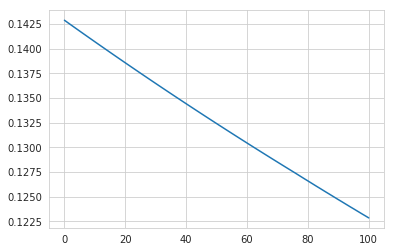

In [106]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

##### 2.2.3. Классификация

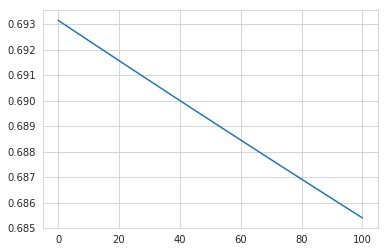

In [107]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.binomial(1, 0.5, size=100)

gb_test = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

### 3. Использование класса GradientBoosting

Проверим, как работает наш бустинг на двух задачах - регрессии и классификации на 2 класса.
Для этого будем использовать игрушечные выборки, полученные с помощью `sklearn.datasets.make_regression` и `sklearn.datasets.make_classificaiton`.

#### 3.1. Задача регрессии

In [108]:
X, y = make_regression(n_samples=100, n_features=2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [109]:
gb_regressor = GradientBoosting(loss=MSELoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_regressor.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val, verbose=False)

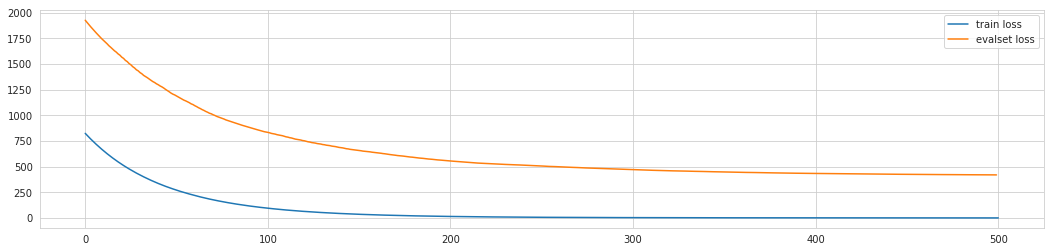

In [110]:
plt.figure(figsize=(18, 4))
plt.plot(gb_regressor.loss_values, label='train loss')
plt.plot(gb_regressor.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "среднее по датасету" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций они должны отличаться как минимум в 100 раз.

*Код в ячейках ниже должен выполняться без ошибок.*

In [111]:
# Train
y_mean = np.mean(y_train) * np.ones_like(y_train)
mse_baseline = mean_squared_error(y_train, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_train)
mse_boosting = mean_squared_error(y_train, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 100)

MSE для предсказания среднего по выборке: 1648.606
MSE для предсказаний бустинга: 1.946


In [112]:
# Val
y_mean = np.mean(y_val) * np.ones_like(y_val)
mse_baseline = mean_squared_error(y_val, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_val)
mse_boosting = mean_squared_error(y_val, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 3)

MSE для предсказания среднего по выборке: 3531.394
MSE для предсказаний бустинга: 839.491


#### 3.2. Задача классификации

In [113]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, flip_y=0.25, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [114]:
gb_classifier = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_classifier.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val)

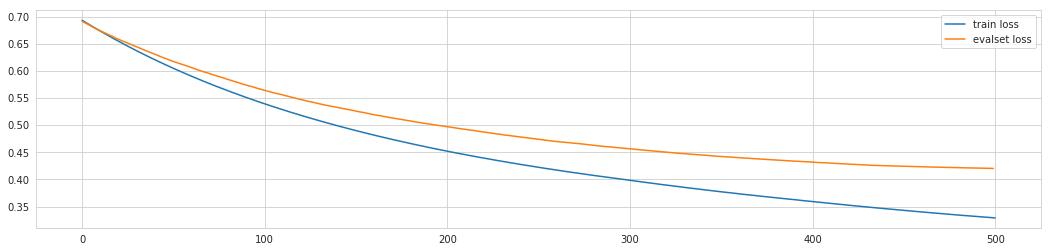

In [115]:
plt.figure(figsize=(18, 4))
plt.plot(gb_classifier.loss_values, label='train loss')
plt.plot(gb_classifier.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "подбрасывание монетки" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций ошибка бустинга должна быть как минимум вдвое меньше.

*Код в ячейках ниже должен выполняться без ошибок.*

In [116]:
# Train
y_random = np.random.binomial(1, 0.5, size=len(y_train))
accuracy_baseline = accuracy_score(y_train, y_random)
print('Accuracy для случайного предсказания: {:.3f}'.format(accuracy_baseline))

y_pred = np.array(gb_classifier.predict(X_train) > 0.5, dtype=np.int)
accuracy_boosting = accuracy_score(y_train, y_pred)
print('Accuracy для предсказаний бустинга: {:.3f}'.format(accuracy_boosting))

np.testing.assert_array_less(1 - accuracy_boosting, (1 - accuracy_baseline) / 2 + 1e-5)

Accuracy для случайного предсказания: 0.487
Accuracy для предсказаний бустинга: 0.912


In [117]:
# Val
y_random = np.random.binomial(1, 0.5, size=len(y_val))
accuracy_baseline = accuracy_score(y_val, y_random)
print('Accuracy для случайного предсказания: {:.3f}'.format(accuracy_baseline))

y_pred = np.array(gb_classifier.predict(X_val) > 0.5, dtype=np.int)
accuracy_boosting = accuracy_score(y_val, y_pred)
print('Accuracy для предсказаний бустинга: {:.3f}'.format(accuracy_boosting))

np.testing.assert_array_less(1 - accuracy_boosting, (1 - accuracy_baseline) / 2 + 1e-5)

Accuracy для случайного предсказания: 0.450
Accuracy для предсказаний бустинга: 0.800


Если все тесты пройдены успешно, попробуйте реализовать дополнительный функционал для вашего класса:
- Реализация ранней остановки обучения (1 балл)
- Реализация вычисления дополнительной метрики качества на каждой итерации (1 балл)
- Реализация бэггинга при обучении отдельных деревьев (1 балл)

Для того, чтобы дополнительные баллы были засчитаны, необходимо реализовать функционал и продемонстрировать результат в ячейке внизу.

### Early stopping in action

In [118]:
gb_regressor_es = GradientBoosting(loss=MSELoss(), n_estimators=500, learning_rate=3.0, max_depth=3, \
                                early_stopping_rounds=25, subsample=0.63)
gb_regressor_es.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val, verbose=False)

early_stopping at 127 round


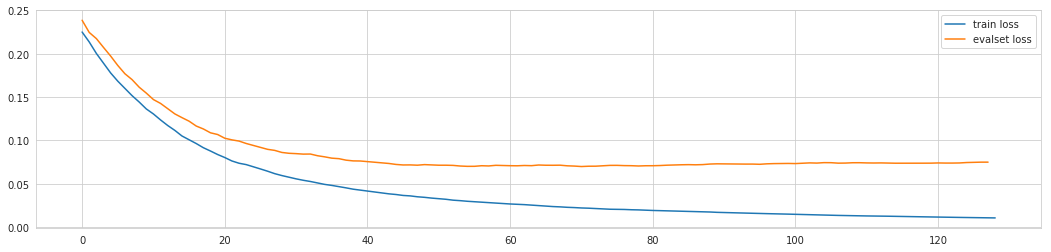

In [119]:
plt.figure(figsize=(18, 4))
plt.plot(gb_regressor_es.loss_values, label='train loss')
plt.plot(gb_regressor_es.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

### R^2 and recall

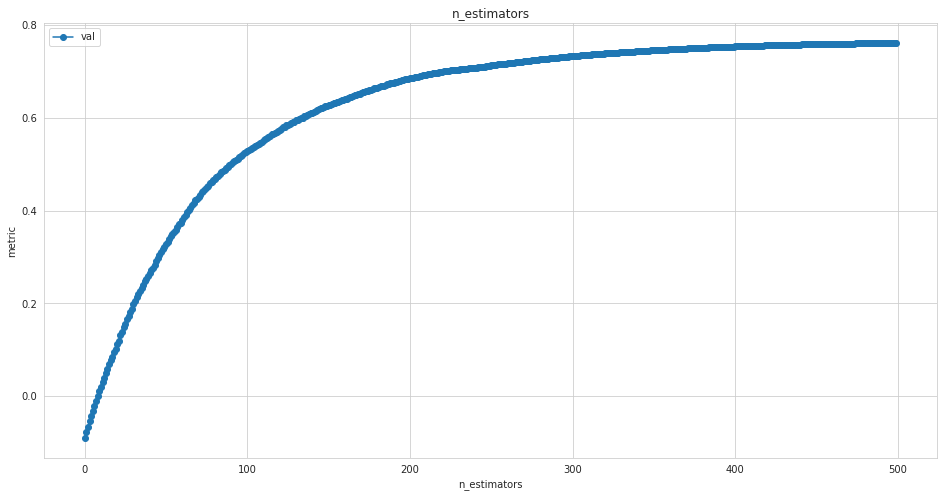

In [120]:
plot_params = {
            'param_name'   : 'n_estimators',
            'param_values' : range(500), 
            'val_values'   : gb_regressor.metric_values_evalset
}
plot_metric(**plot_params)

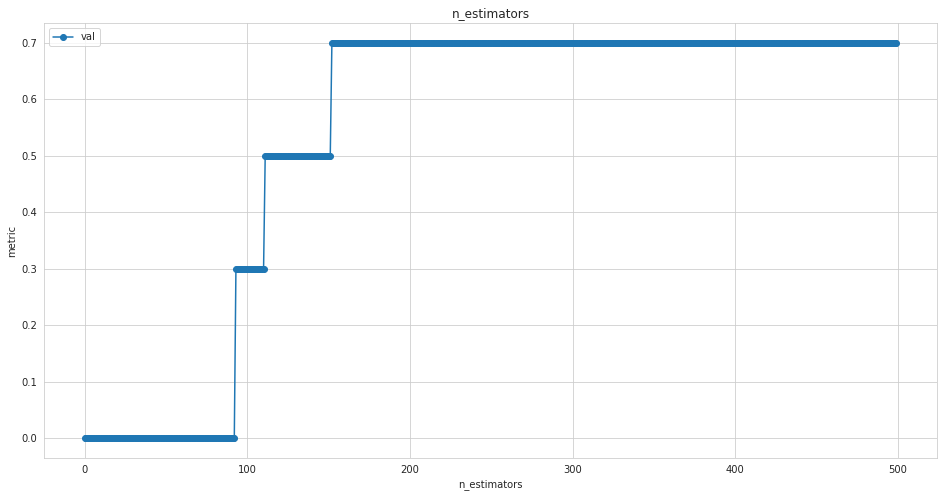

In [121]:
plot_params = {
            'param_name'   : 'n_estimators',
            'param_values' : range(500), 
            'val_values'   : gb_classifier.metric_values_evalset
}
plot_metric(**plot_params)

### Bagging: lf 'subsample' param in my boosting class

## Часть 2. Решение задачи предсказания цены футболиста в FIFA 18 Ultimate Team

Нужно обучить какой-либо из рассмотренных в курсе ансамблей предсказывать трансферную стоимость футболиста из FIFA 18 Ultimate Team. Решение будет оцениваться по метрике MSE на тестовой выборке. Засчитывается только решение, качество которого на тестовой выборке окажется выше, чем у бейзлайна (см. в конце ноутбука).

Данные для обучения - `train_with_targets.csv`, столбец с целевой переменной - `price_ps4`.
Для отправки решения заполните столбец `price_ps4` в файле `test_submission.csv` предсказаниями своей модели на признаках из файла `test.csv` (убедитесь, что порядок следования `player_id` верный).

Для обучения моделей следует использовать:
* \*Свой класс для градиентного бустинга, реализованный выше
* Любые ансамбли из `sklearn` (`RandomForestRegressor`, `GradientBoostingRegressor`, ...)
* Любые фреймворки для градиентного бустинга (`XGBoost`, `LightGBM`, `CatBoost`, ...)
* \*Стекинг/блендинг (свой или тот, что был реализован на лекциях)
* Подбор гиперпараметров с помощью `RandomizedSearch` / `hyperopt` / ... 

Использование пунктов со звездочкой может накинуть дополнительных баллов за задание (по 1 баллу за пункт, т.е. максимум 2 дополнительных балла).

Удачи!

*Ниже приведен пример бейзлайна на случайном лесе из `sklearn`.*

### Baseline на RandomForestClassifier из Sklearn.ensemble

In [122]:
#data_train = pd.read_csv('./data/train_with_targets.csv')

In [123]:
#data_train.head()

In [124]:
#data_train_num = data_train.select_dtypes(include=['int', 'float'])
#data_train_num.fillna(data_train_num.mean(), inplace=True)

In [125]:
#data_train_num.head()

In [126]:
#X = data_train_num.drop(labels=['price_ps4'], axis=1).values[:, 1:]
#y = data_train_num['price_ps4'].values
#print(X.shape, y.shape)

In [127]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=220)
#print(X_train.shape, y_train.shape)
#print(X_val.shape, y_val.shape)

In [128]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, verbose=1, n_jobs=-1)

In [129]:
mse_scorer = make_scorer(mean_squared_error)

In [130]:
scores = cross_validate(rf_regressor, X, y, cv=5, scoring=mse_scorer, n_jobs=4, \
                        return_train_score=True)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jo

In [131]:
print('Random forest baseline:')
pp( scores['train_score'].mean(), 'train' )
pp( scores['test_score'].mean(), 'test' )

Random forest baseline:
train: 2.325e-02
test: 1.400e-01


In [132]:
rf_regressor.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [133]:
rf_regressor_pred_train = rf_regressor.predict(X_train)
rf_regressor_pred_val = rf_regressor.predict(X_val)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [134]:
pp(mean_squared_error(rf_regressor_pred_train, y_train), 'train')
pp(mean_squared_error(rf_regressor_pred_val, y_val), 'val')

train: 2.365e-02
val: 1.328e-01


# MyPrettyXGBoost

In [135]:
class Stacking(BaseEstimator):
    
    def __init__(self):   
        """
        Initialize Stacking class.
        :param num_folds: number of folds to use for meta-features generating.
        """
        num_folds = 7
        self.kfold = KFold(n_splits=num_folds, shuffle=True, random_state=220)
        self.base_estimators = []
        self.meta_estimator = None
    
    def fit(self, X, y, base_estimators, meta_estimator):
        """
        Run training process for base models and for meta-model after.
        :param base_estimators: list of estimator instances (must have .fit() and .predict_proba() methods)
        :param meta_estimator: estimator instance for meta-model (must have .fit() and .predict_proba() methods)
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets 
        """
        self.base_estimators = base_estimators
        self.meta_estimator = meta_estimator
        
        meta_features = []
        meta_labels = []
        
        # For each fold train all base models on other num_folds-1 folds and generate meta-features for it
        folds = self.kfold.split(X)
        for train_idxs, pred_idxs in folds:
            X_train = X[train_idxs]
            y_train = y[train_idxs]
            X_pred = X[pred_idxs]
            y_pred = y[pred_idxs]
            meta_labels.append(y_pred)
            
            fold_predictions = []
            for estimator in self.base_estimators:
                estimator.fit(X_train, y_train)
                fold_predictions.append([estimator.predict(X_pred)])
            meta_features.append(np.asarray(fold_predictions).transpose(1, 0, 2).reshape(X_pred.shape[0], -1))
        
        # Collect all generated meta-features and labels for them
        meta_features = np.concatenate(meta_features)
        meta_labels = np.concatenate(meta_labels)
        
        # Re-fit all base models on the whole dataset
        for estimator in self.base_estimators:
            estimator.fit(X, y)
        
        # Fit the meta-model on meta-features of A
        self.meta_estimator.fit(meta_features, meta_labels)

    
    def predict(self, X):
        meta_features = []
        
        # Generate meta-features of X (C) using base models 
        for estimator in self.base_estimators:
            meta_features.append([estimator.predict(X)])
        meta_features = np.asarray(meta_features).transpose(1, 0, 2).reshape(X.shape[0], -1)
        
        # Predict targets for meta-features of X (C) using meta-model
        return self.meta_estimator.predict(meta_features)

### Preproc

In [136]:
def preproc_test(data, useless_features, cat_features, encoders):
    data = data.drop(labels = ['player_ID'], axis=1)
    
    data = data.drop(labels = useless_features, axis=1)

    for feature in cat_features:
        encode_transform(data, feature, encoders)

    data_num = data.select_dtypes(include=['int', 'float'])
    data_num.fillna(data_num.mean(), inplace=True)

    X_test = data_num.values

    return X_test

def make_feature_vals_score(df, feature):
    d = {}
    
    for val in df[feature].unique():
        d[val] = df[ df[feature] == val ]['price_ps4'].mean()
        
    return d

def sort_feature_vals(df, feature):
    d = make_feature_vals_score(df, feature)
    
    cmp = lambda val: d[val]

    return sorted(df[feature].unique(), key=cmp)

def encode_fit(df, feature, encoders):
    vals = sort_feature_vals(df, feature)
    labels = range( len(vals) )
    
    encoders[feature] = dict( zip(vals, labels) )
    
    df[feature] = df[feature].map( encoders[feature] )
    return   

def encode_transform(df, feature, encoders):  
    df[feature] = df[feature].map( encoders[feature] )
    return

In [137]:
data = pd.read_csv('./data/train_with_targets.csv')

In [138]:
data = data.drop(labels = ['player_ID'], axis=1)

In [139]:
useless_features = ['pace', 'dribbling', 'shooting', 'passing', 'defending', 'physicality'] + \
\
                   ['gk_diving', 'gk_reflexes', 'gk_handling', 'gk_speed', 'gk_kicking', 'gk_positoning'] + \
\
                   ['cb', 'rb', 'lb', 'rwb', 'lwb', 'cdm', 'cm', 'rm', 'lm', 'cam', 'cf', 'rf', 'lf', 'rw', 'lw', 'st']

data = data.drop(labels = useless_features, axis=1)

In [140]:
cat_features = ['revision', 'club', 'league', 'position']

In [141]:
encoders = {}

for feature in cat_features:
    encode_fit(data, feature, encoders)

In [142]:
data_num = data.select_dtypes(include=['int', 'float'])
data_num.fillna(data_num.mean(), inplace=True)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [143]:
y = data_num['price_ps4'].values
#y = data_num['price_ps4']
data_num = data_num.drop(labels=['price_ps4'], axis=1)
X = data_num.values
#X = data_num
print(X.shape, y.shape)

(18629, 40) (18629,)


In [144]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=220)

### XGBoost model

In [145]:
params = {
            #'learning_rate' : 0.3, # eta
            'min_split_loss' : 0.17865987625009996,  # gamma
    
            'n_estimators' : 339,
    
            'max_depth' : 7,
            'min_child_weight' : 1,
            
            'subsample': 0.7325093115913628,
            'colsample_bytree': 0.6748003703040031,
    
            #'reg_lambda': 0.001,
    
            'random_state': 220,
         }

model = XGBRegressor(**params)

In [146]:
#%%time
# Cross validation 1.243e9 test
#mse_scorer = make_scorer(mean_squared_error)
#with parallel_backend('threading'):
#    scores = cross_validate(model, X, y, cv=5, scoring=mse_scorer, n_jobs=4, \
#                           return_train_score=True)

#print('XGBoost scores:')
#pp( scores['train_score'].mean(), 'train' )
#pp( scores['test_score'].mean(), 'test' )

In [147]:
#params = {
            #'eval_set' : [(X_train, y_train), (X_val, y_val)],
            #'eval_metric' : 'rmse',
            #'early_stopping_rounds' : 25,
            #'verbose' : True,
#         }

#model.fit(X_train, y_train, **params)

In [148]:
#p_train = model.predict(X_train)
#p_val = model.predict(X_val)

#err = mean_squared_error(y_train, p_train)
#print('train: {0:.3e}'.format(err))

#err = mean_squared_error(y_val, p_val)
#print('val:   {0:.3e}'.format(err))

In [149]:
#sorted_idx = np.argsort(model.feature_importances_)[::-1]

#for index in sorted_idx:
#    print([X_train.columns[index], model.feature_importances_[index]]) 

## Stacking stuff

In [150]:
stacker = Stacking()
#lasso_meta = Lasso(alpha=0.0005, random_state=220)
linreg_meta = LinearRegression(fit_intercept=False)

In [151]:
fit_params = {
                'base_estimators' : (model,), # завезли только один
                'meta_estimator' : linreg_meta,
}

In [152]:
stacker.fit(X, y, **fit_params)

In [153]:
#p_val = stacker.predict(X_val)
#err = mean_squared_error(y_val, p_val)
#print('val:   {0:.3e}'.format(err))

In [154]:
#%%time
# Stacker cross validation | test: 1.183e+09
#mse_scorer = make_scorer(mean_squared_error)
#with parallel_backend('threading'):
#    scores = cross_validate(stacker, X, y, cv=5, scoring=mse_scorer, n_jobs=4, \
#                           return_train_score=True, fit_params=fit_params)

#print('XGBoost scores:')
#pp( scores['train_score'].mean(), 'train' )
#
#pp( scores['test_score'].mean(), 'test' )

## Bagging stuff

In [155]:
#from sklearn.ensemble import BaggingRegressor

In [156]:
#bagger = BaggingRegressor(base_estimator=model, n_estimators=8, max_samples=0.8, \
#                            max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=True, \
#                            warm_start=False, n_jobs=4, random_state=220, verbose=3)

In [157]:
#with parallel_backend('threading'):
#    regressor.fit(X_train, y_train)

In [158]:
#with parallel_backend('threading'):
#    p_val = regressor.predict(X_train)
#err = mean_squared_error(y_train, p_val)
#print('val:   {0:.3e}'.format(err))

In [159]:
#%%time
# Bagger cross validation
#mse_scorer = make_scorer(mean_squared_error)
#with parallel_backend('threading'):
#    scores = cross_validate(bagger, X, y, cv=5, scoring=mse_scorer, n_jobs=4, \
#                           return_train_score=True)

#print('XGBoost scores:')
#pp( scores['train_score'].mean(), 'train' )
#pp( scores['test_score'].mean(), 'test' )

## Random_search

In [160]:
#mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [161]:
param_distrs = {
                #'learning_rate' : [0.1], # eta
                'min_split_loss' : sp_uniform(0.1, 0.1),  # gamma

                'n_estimators' : sp_randint(335, 400),

                'max_depth' : sp_randint(6, 9),
                'min_child_weight' : sp_randint(1, 2),

                'subsample': sp_uniform(0.7, 0.1),
                'colsample_bytree': sp_uniform(0.65, 0.07),
                
                #'reg_alpha' : sp_uniform(0, 0.2),
                #'reg_lambda' : sp_uniform(0, 0.1),

                'random_state': [220]
                } 

In [162]:
#rand_searcher = RandomizedSearchCV(XGBRegressor(), n_iter=1024, param_distributions=param_distrs, scoring=mse_scorer, \
#                                   cv=5, n_jobs=4, verbose=2)
#with parallel_backend('threading'):
#    rand_searcher.fit(X, y)

In [163]:
#print('Best params:', rand_searcher.best_params_)
#pp(rand_searcher.best_score_, 'Best score')
# cv_results_

In [164]:
#Best params: {'colsample_bytree': 0.6748003703040031, 'max_depth': 7, 'min_child_weight': 1, 'min_split_loss': 0.17865987625009996, 'n_estimators': 339, 'random_state': 220, 'subsample': 0.7325093115913628}
#Best score: -1.243e+09

In [165]:
# fix learning rate = 0.1
# get n_estimators = 150
# search for max_depth & min_child_weight -> 6 & 2
# gamma -> 0.21633129510072557
# alpha / lambda

# Looking for test set

In [166]:
test_set = pd.read_csv('./data/test.csv')

In [167]:
X_test = preproc_test(test_set, useless_features, cat_features, encoders)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [168]:
p_test = stacker.predict(X_test)

In [169]:
submission = pd.read_csv('./data/test_submission.csv')
submission['price_ps4'] = p_test

In [170]:
submission.to_csv('./data/agorodetskiy_hw_3.csv')

### Тестирование:

In [171]:
from sklearn.metrics import mean_squared_error 

In [172]:
my_submission = pd.read_csv('./data/test_submission.csv')
true_submission = pd.read_csv('./data/test_submission.csv')

In [173]:
assert sum(my_submission['player_ID'].values != true_submission['player_ID'].values) == 0

In [174]:
mse = mean_squared_error(my_submission['price_ps4'], true_submssion['price_ps4'])
print(mse)

NameError: name 'true_submssion' is not defined